In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

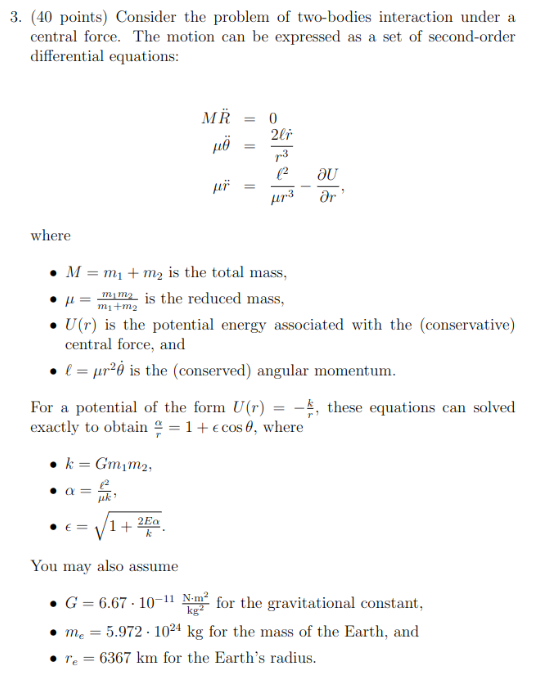
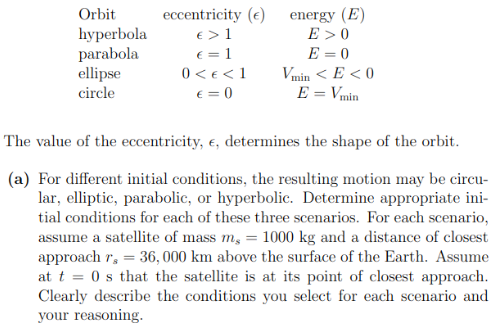

In [2]:
#https://www.lehman.edu/faculty/anchordoqui/chapter25.pdf

def rhs(t,params):
    #params has form: [r, theta, r_dot, theta_dot]
    #params_dot has form: [rho, gamma, rho_dot, gamma_dot]
    r_state, theta_state, rdot_state, thetadot_state = params
    #l = np.sqrt(mu*k*R)
    l = mu*r_state**2 * thetadot_state
    coupled = [rdot_state, #rho
               thetadot_state, #gamma
               (l**2)/(mu**2 * r_state**3) - k/(mu*r_state**2), #rho_dot
               -2*l*rdot_state/(mu*r_state**3)] #gamma dot
    return coupled

#constants
G = 6.67*10**(-11) ## gravitational constant in units of [N * m^2 / kg^2]
m_e = 5.972*10**24 ## mass of Earth in [kg]
m_s = 1000         ## mass of satellite in [kg]
k = G*m_e*m_s
M = m_e + m_s
mu = m_e*m_s/M     ## reduced mass
re = 6378*10**3    ## radius of Earth
rs = 30000*10**3   ## distance satellite orbits above surface of Earth
R = re + rs

#PART A the initial conditions EACH CONDITIONAL STATEMENT EXPLAINS HOW I CHOSE THE CONDITIONS
#PART B IN NEXT CELL
def orbit_type(ecc):
    
    def calc_E(r, ang_mom):
        return ang_mom**2 / (2*mu*r**2) - k/r
    
    #FIRST I CALCULATE THE ENERGY FOR JUST A CIRCULAR ORBIT
    #EQUATIONS COME FROM https://www.lehman.edu/faculty/anchordoqui/chapter25.pdf
    
    l_circ = np.sqrt(mu*k*R)      #ANGULAR MOMENTUM OF CIRCULAR ORBIT
    r0 = R                        #RADIUS OF CIRCULAR ORBIT
    E_circ = calc_E(r0,l_circ)    #ENERGY OF CIRCULAR ORBIT
    E_prop = mu*k**2/(2*l_circ**2)#ENERGY SCALE FACTOR (idea from the Book Analytical Mechanics by Hand and Finch)
    
    if ecc == 0: #circular orbit
        print(f'Circle Energy = {E_circ/E_prop}')
        #INITIAL RADIUS = R
        #INITAL ROTATION = 0 (can always do this)
        #INITIAL R_DOT = 0 (can alwayas do this)
        #INITIAL THETA_DOT = l/(mu*R**2)  COMES FROM l = mu * R**2 theta_dot
        return np.array([r0, 0, 0, l_circ/(mu*R**2)])
    
    elif ecc<1 and ecc>0: #ellipse
        #RMIN AND RMAX EQUATION OBTAINED FROM SAME PDF
        rmin = r0/(1+ecc)
        rmax = r0/(1-ecc)
        E_ell = -k/(2*r0) * (1-ecc**2) 
        print(f'Elliptical Energy: {E_ell/E_prop}')
        print(f'Min energy: {E_circ/E_prop}')
        print(f'Elliptical Energy > Min energy? {E_ell>E_circ}')
        
        #INITIAL RADIUS = rmin
        #INITIAL THETA_DOT = same as before but plug in rmin
        return np.array([rmin, 0, 0, l_circ/(mu*rmin**2)])
    
    elif ecc == 1: #parabolic
        print(f'Parabolic Energy: {calc_E(r0/2,l_circ)/E_prop}')
        #RADIUS OF PARABOLA OBTAINED FROM THE PDF
        #INITIAL RADIUS = R/2
        #INITIAL THETA_DOT = same as before but plug in R/2
        return np.array([r0/2, 0, 0, l_circ/(mu*(r0/2)**2)])
    
    elif ecc>1: #hyperbolic
        rhype = r0/(1+ecc)
        print(f'Hyperbolic Energy: {calc_E(rhype,l_circ)/E_prop}')
        
        #RADIUS OF HYPERBOLA OBTAINED FROM THE PDF
        #INITIAL RADIUS = RHYPE
        #INITIAL THETA_DOT = same as before but plug in RHYPE
        return np.array([rhype, 0, 0, l_circ/(mu*(rhype)**2)])

#THE REST OF THE CODE IS WAS FOR ME TO PLOT THE ORBITS AND CHECK IT IS WORKING, ALL WORK
init_cond = orbit_type(0.8) #PLUG IN ECCENTRICITY VALUES

time_interval = (0,19*10**4) #TWEAK TIME TO GET FULL PERIOD, IF TOO LONG ERROR BUILDS UP, LEADS TO SPIRALS
tvals = np.arange(0,time_interval[-1],1)

sol = solve_ivp(rhs, time_interval, init_cond, t_eval = tvals, method='DOP853')

r_vals = sol.y[0]
theta_vals = sol.y[1]
#rexp = l**2/(mu*k)

# #nob=True
# nob=False
# if nob == True:
#     fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(16,8))
#     axs[0][0].plot(sol.t,r_vals, label='Orbit')
#     #axs[0][0].plot(sol.t,np.ones_like(r_vals)*rexp, label='Expected orbit')
#     axs[0][0].plot(sol.t,np.ones_like(r_vals)*re, label='radius of earth')
#     axs[0][0].set_ylabel('Radius')
#     axs[0][1].plot(sol.t,theta_vals)
#     axs[0][1].set_ylabel('Theta')
#     axs[0][0].set_xlabel('Time')
#     axs[0][1].set_xlabel('Time')
    
#     axs[1][0].plot(sol.t,sol.y[2])
#     axs[1][0].set_ylabel('r dot')
#     axs[1][1].plot(sol.t,sol.y[3])
#     axs[1][1].set_ylabel('theta dot')
#     axs[1][0].set_xlabel('Time')
#     axs[1][1].set_xlabel('Time')
#     axs[0][0].legend()
    
# else:
#     plt.figure(figsize=(10,10))
#     plt.plot(r_vals*np.cos(theta_vals),r_vals*np.sin(theta_vals),label='Orbit')
#     #plt.plot(rexp*np.cos(theta_vals),rexp*np.sin(theta_vals),label='Expected orbit')
#     re_theta = np.linspace(0,2*np.pi,100)
#     plt.plot(re*np.cos(re_theta),re*np.sin(re_theta),label='Earth')
#     plt.axis('equal')
#     plt.legend()
    


Elliptical Energy: -0.3599999999999998
Min energy: -1.0
Elliptical Energy > Min energy? True



ANSWER TO QUESTION FOR PART B:
The observed behavior is occuring becaucse the numerical method accumulates error over time.

It is not seen as much in DOP853 because it has a smaller acuumulation of error. The angular momentum stays 
more constant instead of jumping around a lot like in the RK45.




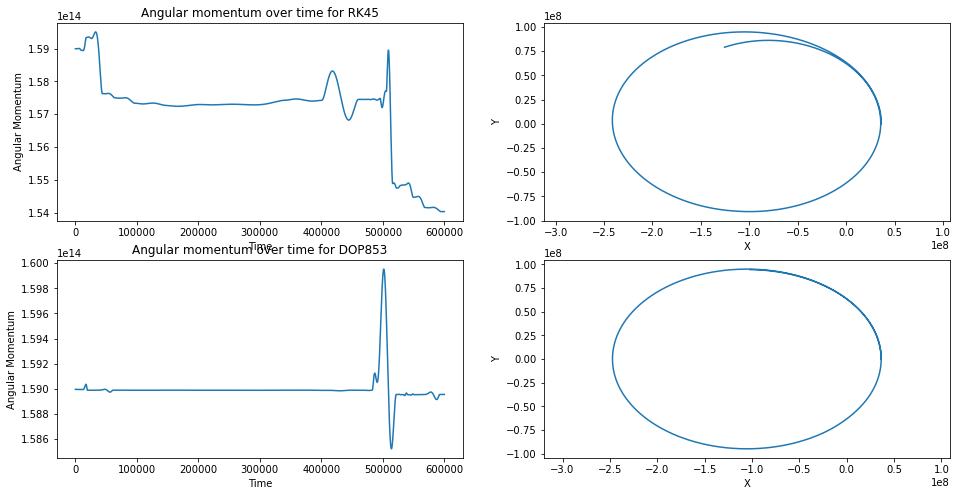

In [3]:
#PART B gonna copy and paste for clarity
def rhs(t,params):
    #params has form: [r, theta, r_dot, theta_dot]
    #params_dot has form: [rho, gamma, rho_dot, gamma_dot]
    r_state, theta_state, rdot_state, thetadot_state = params
    #l = np.sqrt(mu*k*R)
    l = mu*r_state**2 * thetadot_state
    coupled = [rdot_state, #rho
               thetadot_state, #gamma
               (l**2)/(mu**2 * r_state**3) - k/(mu*r_state**2), #rho_dot
               -2*l*rdot_state/(mu*r_state**3)] #gamma dot
    return coupled

#constants
G = 6.67*10**(-11) ## gravitational constant in units of [N * m^2 / kg^2]
m_e = 5.972*10**24 ## mass of Earth in [kg]
m_s = 1000         ## mass of satellite in [kg]
k = G*m_e*m_s
M = m_e + m_s
mu = m_e*m_s/M     ## reduced mass
re = 6378*10**3    ## radius of Earth
rs = 30000*10**3   ## distance satellite orbits above surface of Earth
R = re + rs

init_cond = np.array([(3.64*10**4)*10**3, 0, 0, 1.2*10**-4])
time_interval = (0,60*10**4) #TWEAK TIME TO GET FULL PERIOD, IF TOO LONG ERROR BUILDS UP, LEADS TO SPIRALS
tvals = np.arange(0,time_interval[-1],1)

sol45 = solve_ivp(rhs, time_interval, init_cond, t_eval=tvals, method='RK45')
solDO = solve_ivp(rhs, time_interval, init_cond, t_eval=tvals, method='DOP853')

RKr_vals = sol45.y[0]
RKtheta_vals = sol45.y[1]
RKr_dot_vals = sol45.y[2]
RKtheta_dot_vals = sol45.y[3]
DOr_vals = solDO.y[0]
DOtheta_vals = solDO.y[1]
DOr_dot_vals = solDO.y[2]
DOtheta_dot_vals = solDO.y[3]

RKls = mu * RKr_vals**2 * RKtheta_dot_vals
DOls = mu * DOr_vals**2 * DOtheta_dot_vals
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (16,8))

axs[0][0].set_title('Angular momentum over time for RK45')
axs[0][0].plot(sol45.t,RKls, label='Angular Momentum RK45')
axs[0][0].set_ylabel('Angular Momentum')
axs[0][1].plot(RKr_vals*np.cos(RKtheta_vals),RKr_vals*np.sin(RKtheta_vals),label='RK45 Orbit')
axs[0][1].set_ylabel('Y')
axs[0][0].set_xlabel('Time')
axs[0][1].set_xlabel('X')
axs[0][1].axis('equal')

axs[1][0].set_title('Angular momentum over time for DOP853')
axs[1][0].plot(solDO.t,DOls, label='Angular Momentum DOP853')
axs[1][0].set_ylabel('Angular Momentum')
axs[1][1].plot(DOr_vals*np.cos(DOtheta_vals),DOr_vals*np.sin(DOtheta_vals),label='DOP 853 Orbit')
axs[1][1].set_ylabel('Y')
axs[1][0].set_xlabel('Time')
axs[1][1].set_xlabel('X')
axs[1][1].axis('equal')

string = '''
ANSWER TO QUESTION FOR PART B:
The observed behavior is occuring becaucse the numerical method accumulates error over time.

It is not seen as much in DOP853 because it has a smaller acuumulation of error. The angular momentum stays 
more constant instead of jumping around a lot like in the RK45.

'''
print(string)

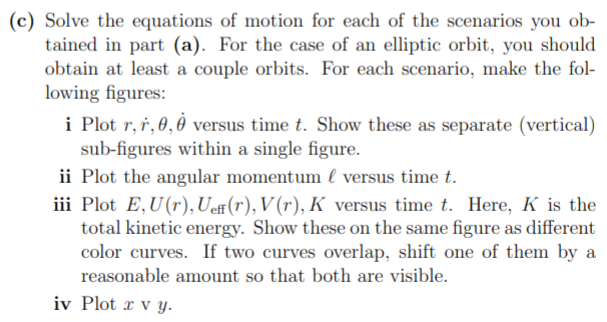
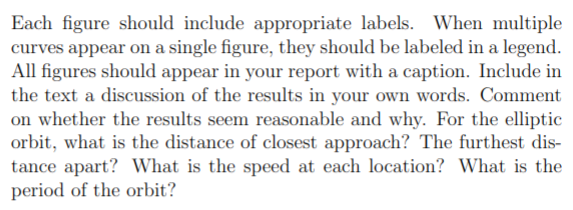


CAPTION FOR FIGURES:

r vs t:
For circular orbit we expect that the radius to stay constant over time and it does

theta vs t:
There should be a linear relationship between theta vs time and we see that

rdot vs t:
rdot should be close to 0 and it is 

theta dot vs t:
Should be a constant angular frequency and it is

orbit:
shows circular orbit

angular momentum:
stays constant which is what is expected

Energy:




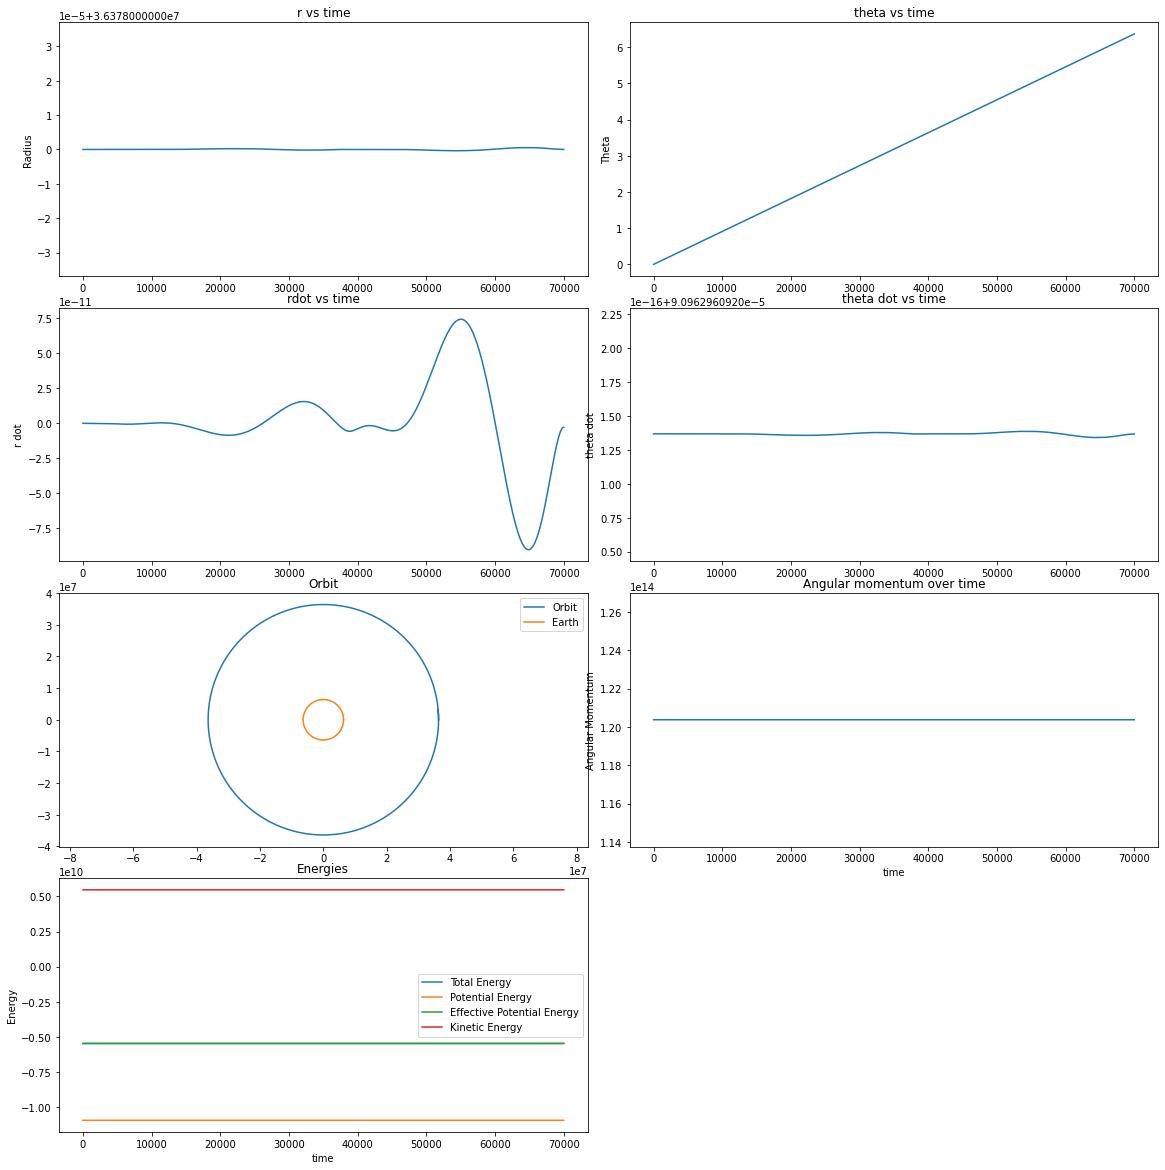

In [4]:
#PART C
def rhs(t,params):
    #params has form: [r, theta, r_dot, theta_dot]
    #params_dot has form: [rho, gamma, rho_dot, gamma_dot]
    r_state, theta_state, rdot_state, thetadot_state = params
    l = mu*r_state**2 * thetadot_state
    coupled = [rdot_state, #rho
               thetadot_state, #gamma
               (l**2)/(mu**2 * r_state**3) - k/(mu*r_state**2), #rho_dot
               -2*l*rdot_state/(mu*r_state**3)] #gamma dot
    return coupled

#constants
G = 6.67*10**(-11) ## gravitational constant in units of [N * m^2 / kg^2]
m_e = 5.972*10**24 ## mass of Earth in [kg]
m_s = 1000         ## mass of satellite in [kg]
k = G*m_e*m_s
M = m_e + m_s
mu = m_e*m_s/M     ## reduced mass
re = 6378*10**3    ## radius of Earth
rs = 30000*10**3   ## distance satellite orbits above surface of Earth
R = re + rs

#PART A the initial conditions EACH CONDITIONAL STATEMENT EXPLAINS HOW I CHOSE THE CONDITIONS
#PART B IN NEXT CELL
def orbit_type(ecc):
    def calc_E(r, ang_mom):
        return ang_mom**2 / (2*mu*r**2) - k/r
    l_circ = np.sqrt(mu*k*R)      #ANGULAR MOMENTUM OF CIRCULAR ORBIT
    r0 = R                        #RADIUS OF CIRCULAR ORBIT
    E_circ = calc_E(r0,l_circ)    #ENERGY OF CIRCULAR ORBIT
    E_prop = mu*k**2/(2*l_circ**2)#ENERGY SCALE FACTOR (idea from the Book Analytical Mechanics by Hand and Finch)
    
    if ecc == 0: #circular orbit
        return np.array([r0, 0, 0, l_circ/(mu*R**2)])
    
    elif ecc<1 and ecc>0: #ellipse
        #RMIN AND RMAX EQUATION OBTAINED FROM SAME PDF
        rmin = r0/(1+ecc)
        rmax = r0/(1-ecc)
        E_ell = -k/(2*r0) * (1-ecc**2) 
        return np.array([rmin, 0, 0, l_circ/(mu*rmin**2)])
    
    elif ecc == 1: #parabolic
        return np.array([r0/2, 0, 0, l_circ/(mu*(r0/2)**2)])
    
    elif ecc>1: #hyperbolic
        rhype = r0/(1+ecc)
        return np.array([rhype, 0, 0, l_circ/(mu*(rhype)**2)])


def plot_params(sol):
    r_vals = sol.y[0]
    theta_vals = sol.y[1]
    
    fig, axs = plt.subplots(ncols=2,nrows=4,figsize=(16,16))
    plt.subplots_adjust(wspace=0.8)

    fig.tight_layout()
    #plot r,theta,thetadot,rdot
    axs[0][0].set_title('r vs time')
    axs[0][0].plot(sol.t,r_vals, label='Orbit')
    axs[0][0].set_ylabel('Radius')
    
    axs[0][1].set_title('theta vs time')
    axs[0][1].plot(sol.t,theta_vals)
    axs[0][1].set_ylabel('Theta')
    
    axs[1][0].set_title('rdot vs time')
    axs[1][0].plot(sol.t,sol.y[2])
    axs[1][0].set_ylabel('r dot')
    
    axs[1][1].set_title('theta dot vs time')
    axs[1][1].plot(sol.t,sol.y[3])
    axs[1][1].set_ylabel('theta dot')
    
    #plot l vs t
    ang_moms = mu * r_vals**2 * sol.y[3]
    axs[2][1].set_title('Angular momentum over time')
    axs[2][1].plot(sol.t,ang_moms, label='Angular Momentum')
    axs[2][1].set_ylabel('Angular Momentum')
    axs[2][1].set_xlabel('time')
    
    #plot x vs y
    axs[2][0].set_title('Orbit')
    axs[2][0].plot(r_vals*np.cos(theta_vals),r_vals*np.sin(theta_vals),label='Orbit')
    re_theta = np.linspace(0,2*np.pi,100)
    axs[2][0].plot(re*np.cos(re_theta),re*np.sin(re_theta),label='Earth')
    axs[2][0].axis('equal')
    axs[2][0].legend()
    
    #energies

    axs[3][0].set_title('Energies')
    axs[3][0].plot(sol.t,0.5*mu*sol.y[2]**2 + ang_moms**2/(2*mu)/r_vals**2 - k/r_vals, label='Total Energy')
    
    axs[3][0].plot(sol.t,-k/r_vals, label='Potential Energy')
    
    axs[3][0].plot(sol.t,-k/r_vals + ang_moms**2/(2*mu)* 1/r_vals**2, label='Effective Potential Energy')
    
    axs[3][0].plot(sol.t,0.5*m_s*(r_vals*sol.y[3])**2, label='Kinetic Energy')
    
    axs[3][0].set_ylabel('Energy')
    axs[3][0].set_xlabel('time')
    axs[3][0].legend()
    fig.delaxes(axs[3][1])
    
    
#Circular

string = '''
FOR THE NEXT SECTIONS THE DISTANCE OF CLOSEST APPROACH IS THE INITIAL RADIAL DISTANCE GIVEN IN 
THE ORBIT TYPE FUNCTION. PERIOD IS ROUGHLY THE FINAL TIME IN TIME INTERVAL FOR CIRCULAR AND ELLIPITICAL.

CAPTION FOR FIGURES:

r vs t:
For circular orbit we expect that the radius to stay constant over time and it does

theta vs t:
There should be a linear relationship between theta vs time and we see that

rdot vs t:
rdot should be close to 0 and it is 

theta dot vs t:
Should be a constant angular frequency and it is

orbit:
shows circular orbit

angular momentum:
stays constant which is what is expected

Energy:
In circular motion we expect all the energies to be constant and they are
'''
print(string)

init_cond = orbit_type(0) #PLUG IN ECCENTRICITY VALUES
time_interval = (0,7*10**4) #TWEAK TIME TO GET FULL PERIOD, IF TOO LONG ERROR BUILDS UP, LEADS TO SPIRALS
tvals = np.arange(0,time_interval[-1],1)
sol = solve_ivp(rhs, time_interval, init_cond, t_eval = tvals, method='DOP853')

plot_params(sol)


CAPTION FOR FIGURES:

r vs t:
For circular orbit we expect that the radius to stay constant over time and it does

theta vs t:
There should be a linear relationship between theta vs time and we see that

rdot vs t:
rdot should be close to 0 and it is 

theta dot vs t:
Should be a constant angular frequency and it is

orbit:
shows circular orbit

angular momentum:
changes only in the 3rd decimal places so stays constant

Energy:
We see Kinetic and Potential energy being traded which is what we expect. Not sure why it wouldn't be traded
with effective potential energy though.



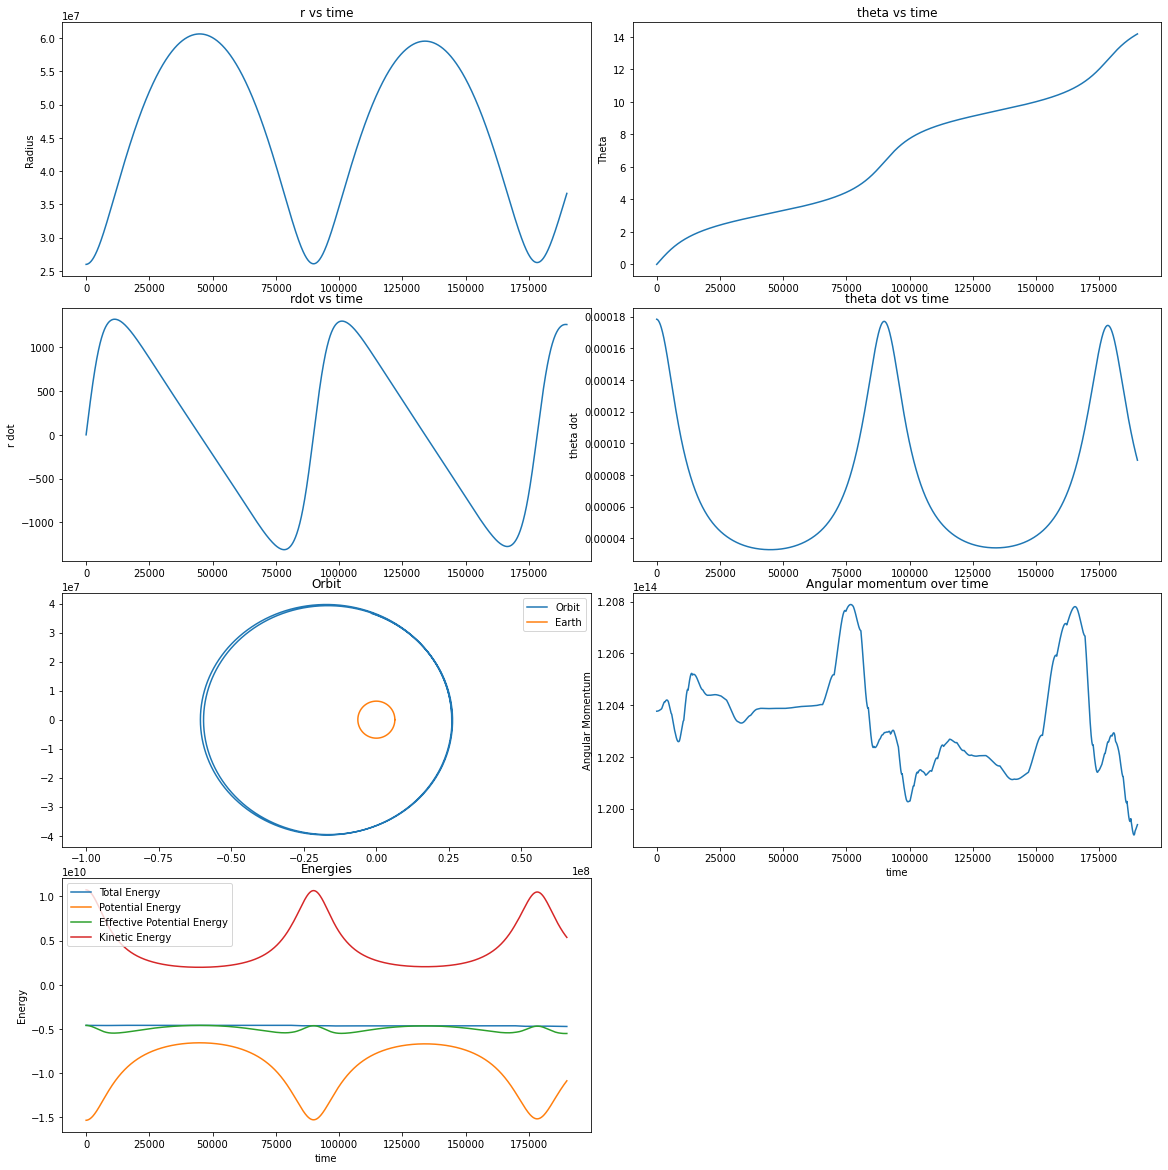

In [9]:
#elliptical second elliptical at end of notebook

string = '''
CAPTION FOR FIGURES:

r vs t:
For circular orbit we expect that the radius to stay constant over time and it does

theta vs t:
There should be a linear relationship between theta vs time and we see that

rdot vs t:
rdot should be close to 0 and it is 

theta dot vs t:
Should be a constant angular frequency and it is

orbit:
shows elliptical orbit

angular momentum:
changes only in the 3rd decimal places so stays constant

Energy:
We see Kinetic and Potential energy being traded which is what we expect. Not sure why it wouldn't be traded
with effective potential energy though.
'''
print(string)


init_cond = orbit_type(0.4) #PLUG IN ECCENTRICITY VALUES
time_interval = (0,19*10**4) #TWEAK TIME TO GET FULL PERIOD, IF TOO LONG ERROR BUILDS UP, LEADS TO SPIRALS
tvals = np.arange(0,time_interval[-1],1)
sol = solve_ivp(rhs, time_interval, init_cond, t_eval = tvals, method='BDF')

plot_params(sol)

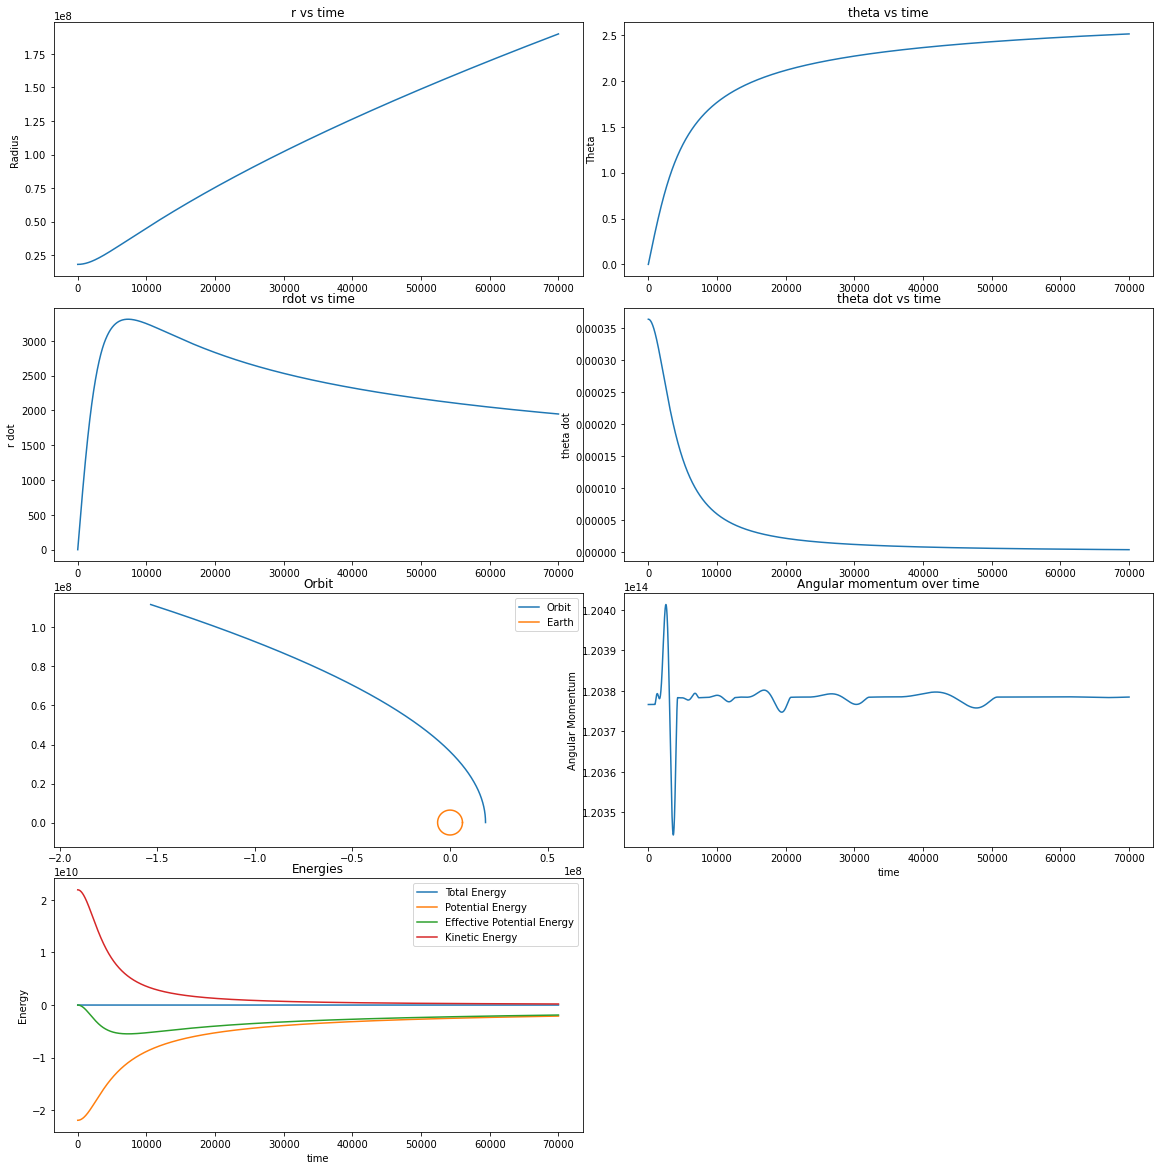

In [6]:
#Parabolic
string = '''
CAPTION FOR FIGURES:

r vs t:
For parabolic we see the radius is increasing with time and is not periodic which is what 
we expect for unbounded motion.

theta vs t:
Reaches a rough asymptote or the change in angle slows down which makes sense.

rdot vs t:
Not sure how to interpret. The change in r increases quickly and then starts to slow down

theta dot vs t:
Starts at the peak of parabola so the frequency increases and then slows down quickly.

orbit:
shows parabolic orbit

angular momentum:
changes only in the 3rd decimal places so stays constant

Energy:
Total energy is 0 which is what we expect. Trading potential and kinetic energy again.
'''
print(string)
init_cond = orbit_type(1) #PLUG IN ECCENTRICITY VALUES
time_interval = (0,7*10**4) #TWEAK TIME TO GET FULL PERIOD, IF TOO LONG ERROR BUILDS UP, LEADS TO SPIRALS
tvals = np.arange(0,time_interval[-1],1)
sol = solve_ivp(rhs, time_interval, init_cond, t_eval = tvals, method='DOP853')

plot_params(sol)


CAPTION FOR FIGURES:

r vs t:
Radius increases over time, unbounded as we expect. 

theta vs t:
Reaches similar asymptote like parabolic

rdot vs t:
Analagous to parabolic.

theta dot vs t:
Analagous to parabolic.

orbit:
shows elliptical orbit

angular momentum:
changes only in the 3rd decimal places so it stays constant

Energy:
We see Kinetic and Potential energy being traded which is what we expect. Positive Energy which is what we expect.




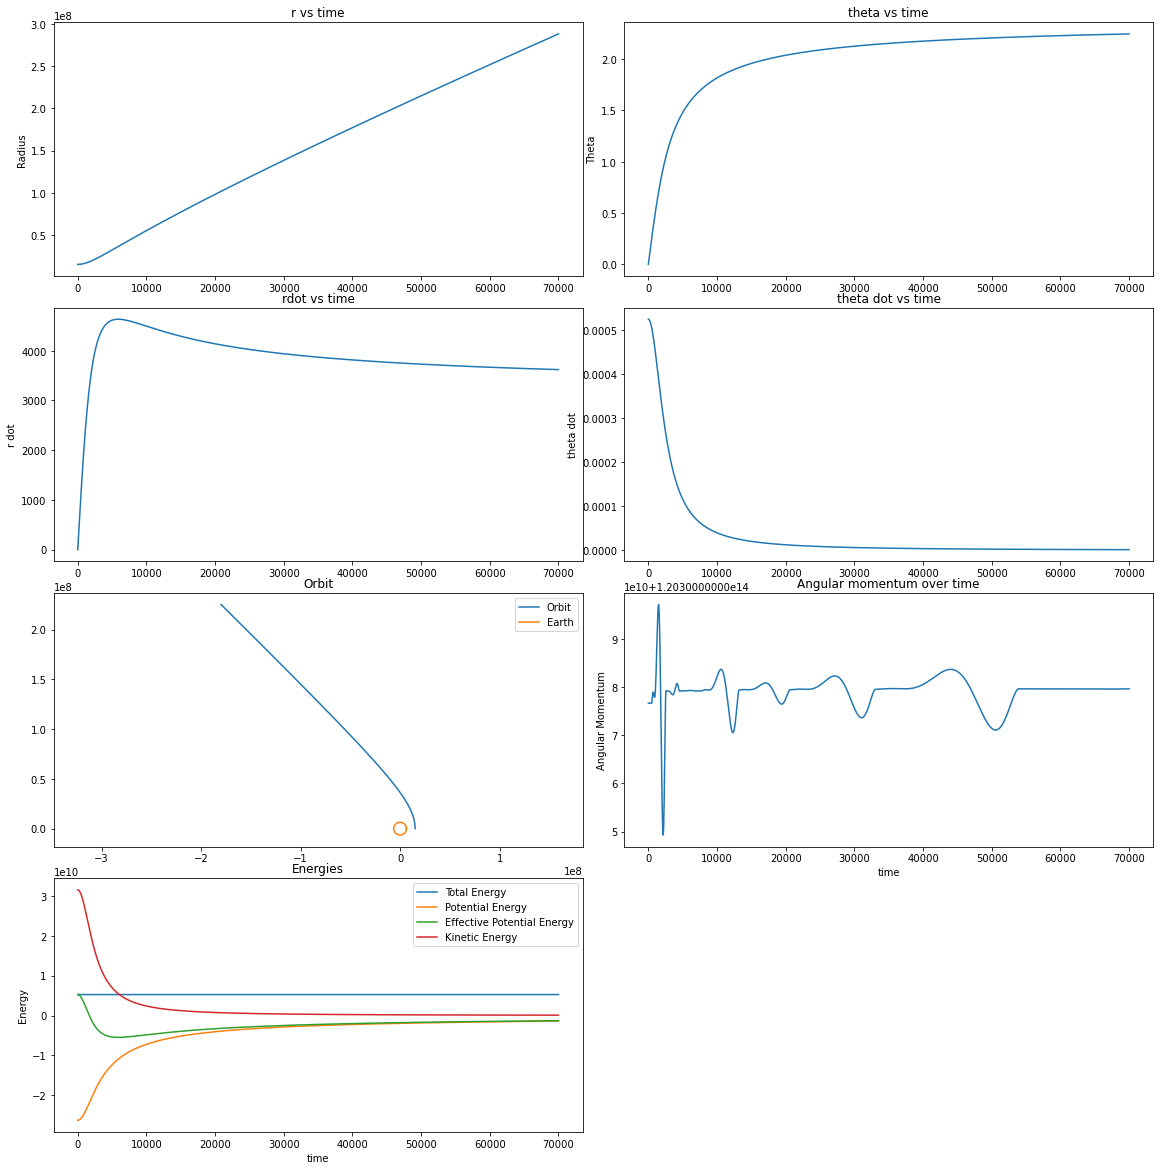

In [10]:
#hyper bolic
string = '''
CAPTION FOR FIGURES:

r vs t:
Radius increases over time, unbounded as we expect. 

theta vs t:
Reaches similar asymptote like parabolic

rdot vs t:
Analagous to parabolic.

theta dot vs t:
Analagous to parabolic.

orbit:
shows elliptical orbit

angular momentum:
changes only in the 3rd decimal places so it stays constant

Energy:
We see Kinetic and Potential energy being traded which is what we expect. Positive Energy which is what we expect.

'''
print(string)

init_cond = orbit_type(1.4) #PLUG IN ECCENTRICITY VALUES
time_interval = (0,7*10**4) #TWEAK TIME TO GET FULL PERIOD, IF TOO LONG ERROR BUILDS UP, LEADS TO SPIRALS
tvals = np.arange(0,time_interval[-1],1)
sol = solve_ivp(rhs, time_interval, init_cond, t_eval = tvals, method='DOP853')

plot_params(sol)

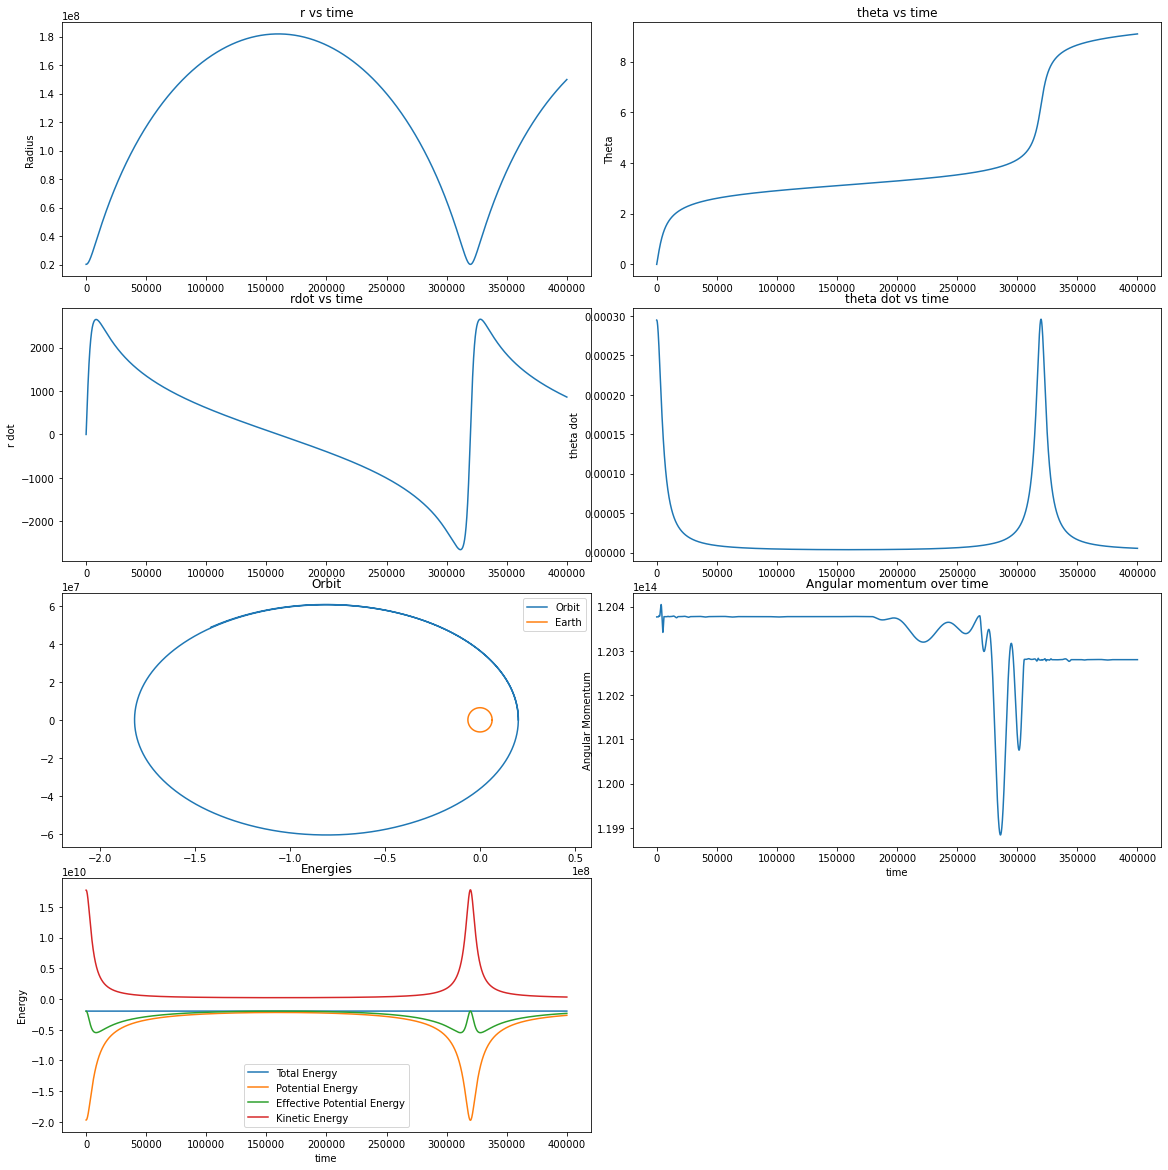

In [8]:
#elliptical number two
init_cond = orbit_type(0.8) #PLUG IN ECCENTRICITY VALUES
time_interval = (0,40*10**4) #TWEAK TIME TO GET FULL PERIOD, IF TOO LONG ERROR BUILDS UP, LEADS TO SPIRALS
tvals = np.arange(0,time_interval[-1],1)
sol = solve_ivp(rhs, time_interval, init_cond, t_eval = tvals, method='DOP853')

plot_params(sol)